# LSTM for Time Series
### With TensorFlow/Keras: Multivariate time series

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow.keras.models as tkm
import tensorflow.keras.layers as tkl

## Load and transform dataset

In [8]:
ds = pd.read_csv('D:/data/csv/airpolution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))
ds.drop('No', axis=1, inplace=True)
ds.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
ds.index.name = 'date'
ds['pollution'].fillna(0, inplace=True)
ds = ds[24:] # drop first 24 hours
ds.to_csv('D:/data/csv/pollution.csv')
ds.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Load and plot data

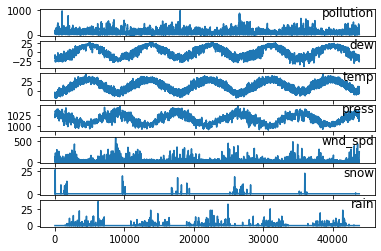

In [33]:
dataset = pd.read_csv('D:/data/csv/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

### Data preparation

In [34]:
def ts2sup_df(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [35]:
values = ds.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = ts2sup_df(scaled, 1, 1)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True) #keep only cols to  predict
print(reframed.head())
 

### Split into train and test / inputs and outputs

In [44]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


## Modelling

Epoch 1/50
122/122 - 1s - loss: 0.0622 - val_loss: 0.0511
Epoch 2/50
122/122 - 1s - loss: 0.0415 - val_loss: 0.0504
Epoch 3/50
122/122 - 1s - loss: 0.0238 - val_loss: 0.0368
Epoch 4/50
122/122 - 1s - loss: 0.0162 - val_loss: 0.0209
Epoch 5/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0151
Epoch 6/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0149
Epoch 7/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0148
Epoch 8/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0148
Epoch 9/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0145
Epoch 10/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0145
Epoch 11/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 12/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0141
Epoch 13/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0137
Epoch 14/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0138
Epoch 15/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 16/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0136
Epoch 17/50
122/122 - 1s - loss: 0.0144 - val_loss: 0.0138
Epoch 

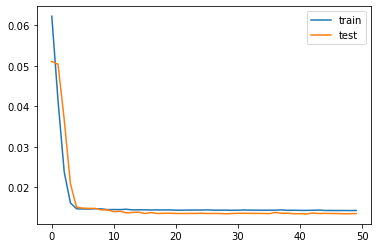

In [36]:
model = tkm.Sequential()
model.add(tkl.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tkl.Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Validation

In [41]:

#pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_pred = np.concatenate((pred, test_X[:, 1:]), axis=1)
inv_pred = scaler.inverse_transform(inv_pred)
inv_pred = inv_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.636


## Credits & Links

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/